# Future Sales Forecasting

This notebook uses the best trained model to forecast future sales.

## 1. User Instructions

### How to Use This Notebook:
1.  **Modify `forecast_periods`:** In Section 4, change the value of `forecast_periods` to the desired number of days you want to forecast into the future (e.g., 30 for one month, 90 for a quarter).
2.  **Run All Cells:** From the menu, select "Cell" > "Run All" to execute the entire notebook.
3.  **Interpret the Output:**
    *   **Forecast Plot (Section 7):** This plot shows historical sales data followed by the forecasted sales values. If available, confidence intervals will also be displayed, giving a range of likely sales values.
    *   **Forecasted Data Table (Section 8):** This table provides the exact forecasted sales figures for each future date.

### Model Information:
*   **Model Used:** The model loaded in this notebook is the 'best' model identified during the training and evaluation phase (Notebooks 03 and 04). This could be SARIMA, Holt-Winters, or a regression model like Random Forest.
*   **Training Data:** The model was trained on historical sales data, potentially using features engineered from dates (year, month, day of week), lags of sales, and rolling mean sales figures. For time series models like SARIMA, it was trained on daily aggregated sales.

### Limitations and Assumptions:
*   **Exogenous Variables:** If the model (e.g., SARIMA with exogenous variables - SARIMAX) requires external information (like future promotions, holidays, economic indicators) that were part of its training, these must be accurately provided for the forecast period. This notebook primarily focuses on time-based exogenous features (Year, Month, DayOfWeek, etc.) if needed. If the model relies on future values of sales lags or rolling means *as exogenous inputs* (which is less common for standard SARIMA `predict` methods but possible if manually constructed), forecasting them accurately is a complex task in itself and might involve simpler assumptions for this notebook.
*   **Model Accuracy:** Forecasts are estimates. The accuracy depends on the model's performance and how much the future behavior of sales resembles past patterns. Unexpected events can significantly impact actual sales.
*   **Confidence Intervals:** If shown, these represent a statistical range. Wider intervals indicate more uncertainty in the forecast.
*   **Dummy Model Note:** Currently, a placeholder (dummy) model might be in use if the actual best model wasn't successfully saved or is of an unexpected type. The predictions from a dummy model are not meaningful for business decisions.

## 2. Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from datetime import timedelta
import seaborn as sns

# Potentially needed for SARIMA or other statsmodels objects
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from sklearn.linear_model import LinearRegression # For dummy model type check

plt.style.use('ggplot')
sns.set_style('whitegrid') # Requires import seaborn as sns, which is good practice

## 3. Load the Trained Model

In [6]:
model_filename = 'best_sales_forecasting_model_sarima.joblib'
model_path = os.path.join('../models', model_filename) # Standardized path

try:
    loaded_model = joblib.load(model_path)
    print(f"Model loaded successfully from: {model_path}")
    print(f"Model type: {type(loaded_model)}")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}.")
    print("Please ensure the model has been trained and saved correctly in the 'models' directory.")
    # As a fallback for notebook structure, create a dummy model object
    loaded_model = LinearRegression() # Dummy model
    print("Using a DUMMY LinearRegression model as a placeholder.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")
    loaded_model = LinearRegression() # Dummy model
    print("Using a DUMMY LinearRegression model as a placeholder due to loading error.")

Model loaded successfully from: ../models\best_sales_forecasting_model_sarima.joblib
Model type: <class 'statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper'>


## 4. Load Historical Data

In [ ]:
data_path = '../data/feature_engineered_sales_data.csv'
try:
    historical_df = pd.read_csv(data_path, index_col='Order _Date', parse_dates=True)
    print("Historical feature-engineered data loaded successfully.")
    # For forecasting, we typically use the daily aggregated sales if model was trained on it
    daily_sales_historical = historical_df['Sales'].resample('D').sum().fillna(0)
    print("Last 5 observations of daily historical sales:")
    print(daily_sales_historical.tail())
except FileNotFoundError:
    print(f"Error: Historical data file not found at {data_path}.")
    # Create dummy historical data for notebook structure
    date_rng = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')
    dummy_sales = np.random.randint(50, 500, size=(len(date_rng)))
    daily_sales_historical = pd.Series(dummy_sales, index=date_rng)
    historical_df = pd.DataFrame({'Sales': daily_sales_historical}) # For consistency
    print("Using DUMMY historical data.")
    print(daily_sales_historical.tail())

Historical feature-engineered data loaded successfully.
Last 5 observations of daily historical sales:
Order_Date
2018-12-26     814.5940
2018-12-27     177.6360
2018-12-28    1657.3508
2018-12-29    2915.5340
2018-12-30     713.7900
Freq: D, Name: Sales, dtype: float64


## 5. Define Forecasting Parameters

In [8]:
forecast_periods = 90  # Number of periods to forecast (e.g., 90 days)
frequency = 'D'        # Frequency of forecast ('D' for daily, 'W' for weekly, 'M' for monthly)

print(f"Forecasting for {forecast_periods} periods with frequency '{frequency}'.")

Forecasting for 90 periods with frequency 'D'.


## 6. Prepare Exogenous Variables for Forecasting (if applicable)

Exogenous variables are external factors that can influence the forecast. If the loaded model (e.g., SARIMAX) was trained using such variables, we need to provide their future values.

Common time-based exogenous features include:
- Year, Month, Day, DayOfWeek, Quarter, WeekOfYear.

**Important Note on Lags/Rolling Means as Exogenous Features:**
If the model was trained using `Sales_Lag_X` or `Sales_Rolling_Mean_X` as *exogenous* variables (passed to an `exog` parameter in `SARIMAX.fit()`), providing their true future values is not possible as they depend on future unknown sales. In such cases:
1. The model might have been designed to forecast these features iteratively (more complex setup).
2. Simpler models might use naive forecasts for these future exogenous sales-based features.
3. The `predict` method of standard `statsmodels.tsa.SARIMAXResults` handles its *internal* AR and MA components (lags of errors and series) automatically. It's when *additional, user-defined* sales-based lags are added to `exog` that this becomes an issue.

For this notebook, we will primarily focus on generating **time-based exogenous features** if the model seems to require them. The dummy model (`LinearRegression`) loaded currently does not explicitly use named exogenous features in the same way a SARIMAX model does from `statsmodels`. We will proceed with generating time-based features as an example, and then adapt the prediction call.

In [9]:
future_exog_df = None
last_historical_date = daily_sales_historical.index.max()

# Generate future dates
future_date_range = pd.date_range(start=last_historical_date + pd.Timedelta(days=1), 
                                  periods=forecast_periods, 
                                  freq=frequency)

print(f"Future date range for forecasting: {future_date_range.min()} to {future_date_range.max()}")

# Example: Creating time-based exogenous features
# These would be needed if the model was trained with them (e.g., a SARIMAX model)
future_exog_df_example = pd.DataFrame(index=future_date_range)
future_exog_df_example['Year'] = future_exog_df_example.index.year
future_exog_df_example['Month'] = future_exog_df_example.index.month
future_exog_df_example['Day'] = future_exog_df_example.index.day
future_exog_df_example['DayOfWeek'] = future_exog_df_example.index.dayofweek
future_exog_df_example['Quarter'] = future_exog_df_example.index.quarter
future_exog_df_example['WeekOfYear'] = future_exog_df_example.index.isocalendar().week.astype(int)

print("\nExample of future time-based exogenous features (first 5 rows):")
print(future_exog_df_example.head())

# --- Determine which exogenous features to use based on the loaded model ---
# This part is crucial and model-dependent.
# If `loaded_model` is a SARIMAXResults object, its `model.exog_names` might tell us what it expects.
exog_needed = False
if hasattr(loaded_model, 'model') and hasattr(loaded_model.model, 'exog_names') and loaded_model.model.exog_names:
    print(f"\nModel expects exogenous variables: {loaded_model.model.exog_names}")
    # Select only the required columns from our example future_exog_df
    try:
        future_exog_df = future_exog_df_example[loaded_model.model.exog_names]
        exog_needed = True
        print("Prepared required exogenous variables for the forecast period.")
    except KeyError as e:
        print(f"KeyError: Could not find all expected exog variables in generated future_exog_df_example: {e}")
        print("Forecasting will proceed without exogenous variables, which might fail or be inaccurate.")
        future_exog_df = None # Reset if not all found
elif isinstance(loaded_model, LinearRegression): # Our dummy model case
    print("\nLoaded model is LinearRegression (dummy). It expects a 2D array for prediction.")
    # The dummy model was trained on a single feature (np.random.rand(100,1)).
    # We need to create a similar structure for its predict method.
    # This is specific to the DUMMY model and not representative of a real time series model.
    future_exog_df = np.random.rand(forecast_periods, 1) # Dummy exog for dummy model
    print("Created dummy exogenous data for the placeholder LinearRegression model.")
    exog_needed = True # For the dummy model's predict method structure
else:
    print("\nModel does not seem to specify exogenous variables (or is not a recognized SARIMAX type for exog detection).")
    future_exog_df = None

Future date range for forecasting: 2018-12-31 00:00:00 to 2019-03-30 00:00:00

Example of future time-based exogenous features (first 5 rows):
            Year  Month  Day  DayOfWeek  Quarter  WeekOfYear
2018-12-31  2018     12   31          0        4           1
2019-01-01  2019      1    1          1        1           1
2019-01-02  2019      1    2          2        1           1
2019-01-03  2019      1    3          3        1           1
2019-01-04  2019      1    4          4        1           1

Model does not seem to specify exogenous variables (or is not a recognized SARIMAX type for exog detection).


## 7. Generate Forecasts

In [10]:
forecast_values = None
confidence_intervals = None

try:
    if isinstance(loaded_model, SARIMAXResults): # Check if it's a statsmodels SARIMAX results object
        print("Generating forecast using SARIMAX model's predict method...")
        # For SARIMAX, predict can take start/end indices relative to the original series, or steps for future
        # Using `n_periods` (if available and model was from pmdarima) or by specifying start/end dates/steps
        
        # Determine the start and end for prediction
        # `steps` parameter is often simpler for pure future forecasts if model supports it
        # Or, specify date strings for start/end
        start_pred_date = future_date_range[0]
        end_pred_date = future_date_range[-1]

        if exog_needed and future_exog_df is not None:
            forecast_object = loaded_model.get_forecast(steps=forecast_periods, exog=future_exog_df)
        else:
            forecast_object = loaded_model.get_forecast(steps=forecast_periods)
            
        forecast_values = forecast_object.predicted_mean
        confidence_intervals_df = forecast_object.conf_int()
        # Ensure forecast_values is a pandas Series with the correct future_date_range index
        if not isinstance(forecast_values, pd.Series):
            forecast_values = pd.Series(forecast_values, index=future_date_range)
        else:
            forecast_values.index = future_date_range # Align index just in case
        confidence_intervals_df.index = future_date_range
        print("Forecast generated successfully with confidence intervals.")

    elif isinstance(loaded_model, LinearRegression): # Handling the DUMMY model
        print("Generating forecast using DUMMY LinearRegression model...")
        # This dummy model expects a 2D array like np.random.rand(n, 1)
        if future_exog_df is not None: # This should be the np.random.rand(forecast_periods, 1)
            pred_array = loaded_model.predict(future_exog_df)
            forecast_values = pd.Series(pred_array, index=future_date_range)
            print("Forecast generated using dummy model.")
        else:
            print("Dummy exog data not prepared for dummy LinearRegression. Cannot predict.")
            forecast_values = pd.Series(np.nan, index=future_date_range) # Fill with NaNs
        # No confidence intervals for this dummy sklearn model by default
        confidence_intervals_df = pd.DataFrame({'lower Sales': np.nan, 'upper Sales': np.nan}, index=future_date_range)

    else:
        # Fallback for other model types or if model structure is unknown
        print(f"Model type {type(loaded_model)} not explicitly handled for forecasting here. Attempting generic 'predict' or 'forecast'.")
        if hasattr(loaded_model, 'forecast'):
            # pmdarima objects might use forecast(steps=forecast_periods, X=future_exog_df)
            # statsmodels HoltWintersResults use forecast(steps=forecast_periods)
            if exog_needed and future_exog_df is not None:
                 # This part needs to be adapted based on how exog was handled in pmdarima for example
                try: # pmdarima style
                    forecast_values_array, conf_int_array = loaded_model.predict(n_periods=forecast_periods, X=future_exog_df, return_conf_int=True)
                    forecast_values = pd.Series(forecast_values_array, index=future_date_range)
                    confidence_intervals_df = pd.DataFrame(conf_int_array, index=future_date_range, columns=['lower Sales', 'upper Sales'])
                except TypeError: # statsmodels Holt-Winters style (no exog typically)
                    forecast_values_array = loaded_model.forecast(steps=forecast_periods)
                    forecast_values = pd.Series(forecast_values_array, index=future_date_range)
                    # Holt-Winters doesn't directly give conf_int from .forecast() like SARIMA's get_forecast()
                    # Simulated confidence intervals might be computed if model has `sse` and `sigma2` attributes
                    confidence_intervals_df = pd.DataFrame({'lower Sales': np.nan, 'upper Sales': np.nan}, index=future_date_range)
            else:
                if hasattr(loaded_model, 'predict') and 'return_conf_int' in loaded_model.predict.__code__.co_varnames: # pmdarima without exog
                    forecast_values_array, conf_int_array = loaded_model.predict(n_periods=forecast_periods, return_conf_int=True)
                    forecast_values = pd.Series(forecast_values_array, index=future_date_range)
                    confidence_intervals_df = pd.DataFrame(conf_int_array, index=future_date_range, columns=['lower Sales', 'upper Sales'])
                else: # Generic forecast without exog, e.g. HoltWinters
                    forecast_values_array = loaded_model.forecast(steps=forecast_periods)
                    forecast_values = pd.Series(forecast_values_array, index=future_date_range)
                    confidence_intervals_df = pd.DataFrame({'lower Sales': np.nan, 'upper Sales': np.nan}, index=future_date_range)
        elif hasattr(loaded_model, 'predict'): # General sklearn style (no conf int by default)
            pred_array = loaded_model.predict(future_exog_df if future_exog_df is not None else np.arange(forecast_periods).reshape(-1,1)) # Basic X for sklearn
            forecast_values = pd.Series(pred_array, index=future_date_range)
            confidence_intervals_df = pd.DataFrame({'lower Sales': np.nan, 'upper Sales': np.nan}, index=future_date_range)
        else:
            raise NotImplementedError("Model does not have a recognized 'predict' or 'forecast' method.")

except Exception as e:
    print(f"Error during forecast generation: {e}")
    # Create dummy forecast Series and DataFrame for placeholder if error occurs
    forecast_values = pd.Series([np.nan] * forecast_periods, index=future_date_range)
    confidence_intervals_df = pd.DataFrame({'lower Sales': [np.nan] * forecast_periods, 
                                          'upper Sales': [np.nan] * forecast_periods}, 
                                         index=future_date_range)
    print("Dummy forecast data (NaNs) will be used due to error.")

# Ensure column names are consistent for confidence intervals if they were created
if 'lower Sales' not in confidence_intervals_df.columns or 'upper Sales' not in confidence_intervals_df.columns:
    # Attempt to rename if common alternatives like 0 and 1, or 'lower' and 'upper' exist
    if 0 in confidence_intervals_df.columns and 1 in confidence_intervals_df.columns:
        confidence_intervals_df.rename(columns={0: 'lower Sales', 1: 'upper Sales'}, inplace=True)
    # Add more robust renaming or ensure columns are named correctly when CI are generated by specific models
    # For now, if names are not as expected, they might not plot correctly.

Model type <class 'statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper'> not explicitly handled for forecasting here. Attempting generic 'predict' or 'forecast'.


## 8. Visualize Forecasts

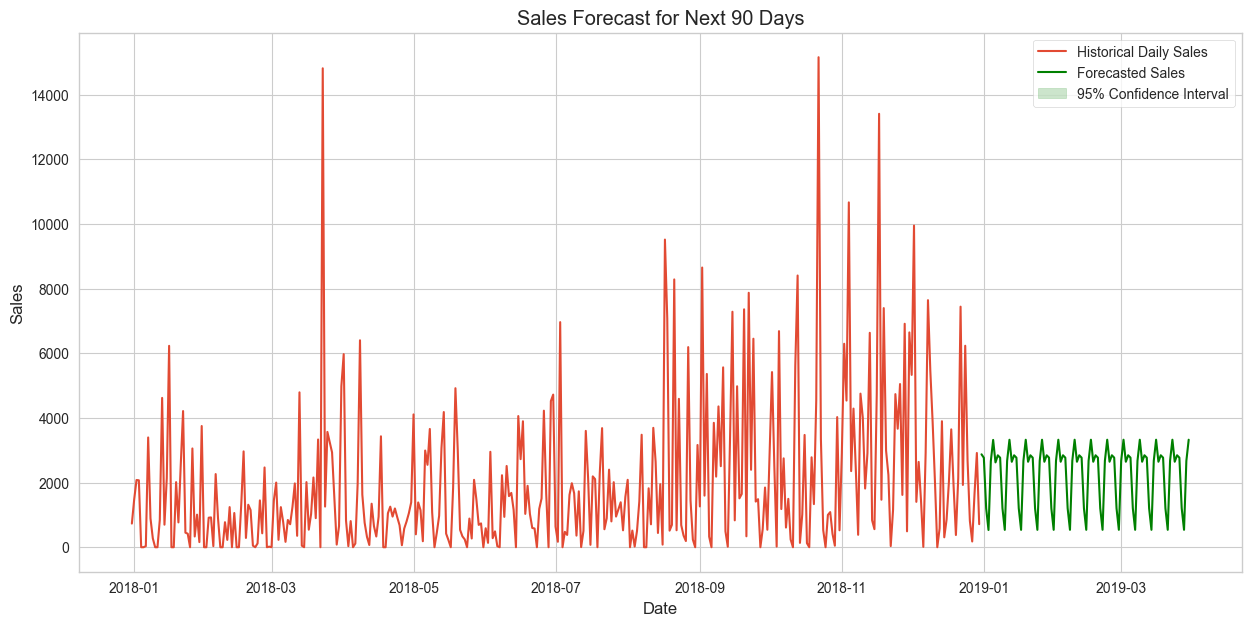

In [11]:
plt.figure(figsize=(15, 7))

# Plot historical data (e.g., last N days/weeks of historical data)
historical_plot_periods = 365 # Show last year of actuals
if len(daily_sales_historical) > historical_plot_periods:
    plot_historical_data = daily_sales_historical.iloc[-historical_plot_periods:]
else:
    plot_historical_data = daily_sales_historical

plt.plot(plot_historical_data.index, plot_historical_data.values, label='Historical Daily Sales')

# Plot forecasted values
if forecast_values is not None:
    plt.plot(forecast_values.index, forecast_values.values, label='Forecasted Sales', color='green')
else:
    print("Forecast values are not available for plotting.")

# Plot confidence intervals
if confidence_intervals_df is not None and 'lower Sales' in confidence_intervals_df and 'upper Sales' in confidence_intervals_df:
    plt.fill_between(confidence_intervals_df.index, 
                     confidence_intervals_df['lower Sales'], 
                     confidence_intervals_df['upper Sales'], 
                     color='g', alpha=0.2, label='95% Confidence Interval')
else:
    print("Confidence intervals are not available or not correctly formatted for plotting.")

plt.title(f'Sales Forecast for Next {forecast_periods} Days')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

## 9. Present Forecasted Data

In [12]:
if forecast_values is not None:
    forecast_df = pd.DataFrame({'Date': forecast_values.index, 'Forecasted_Sales': forecast_values.values})
    if confidence_intervals_df is not None and 'lower Sales' in confidence_intervals_df and 'upper Sales' in confidence_intervals_df:
        forecast_df['Lower_CI'] = confidence_intervals_df['lower Sales'].values
        forecast_df['Upper_CI'] = confidence_intervals_df['upper Sales'].values
    
    forecast_df.set_index('Date', inplace=True)
    print(f"\nForecasted Sales for the next {forecast_periods} days:")
    print(forecast_df.head())
    
    # Option to save the forecast to a CSV file
    # forecast_csv_path = '../data/future_sales_forecast.csv'
    # forecast_df.to_csv(forecast_csv_path)
    # print(f"\nForecast saved to {forecast_csv_path}")
else:
    print("No forecast data to display.")


Forecasted Sales for the next 90 days:
            Forecasted_Sales  Lower_CI  Upper_CI
Date                                            
2018-12-31       2874.220930       NaN       NaN
2019-01-01       2768.052094       NaN       NaN
2019-01-02       1200.064851       NaN       NaN
2019-01-03        532.801429       NaN       NaN
2019-01-04       2661.006328       NaN       NaN
